In [1]:
!nvidia-smi

Sat Sep 28 10:36:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch --progress-bar off
!pip install -qqq torchvision --progress-bar off
!pip install -qqq transformers --progress-bar off
!pip install -qqq accelerate --progress-bar off
!pip install -qqq bitsandbytes --progress-bar off
!pip install -qqq datasets --progress-bar off # downloads datasets from huggingface repository
!pip install -qqq peft --progress-bar off # fine-tuning method/ algo
!pip install -qqq trl --progress-bar off # trainer or supervised fine-tuning trainer librabry
!pip install -qqq colored --progress-bar off

In [12]:
!pip uninstall torch torchvision transformers
!pip install torch torchvision transformers


Found existing installation: torch 2.4.1
Uninstalling torch-2.4.1:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchrun
    /usr/local/lib/python3.10/dist-packages/functorch/*
    /usr/local/lib/python3.10/dist-packages/torch-2.4.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torch/*
    /usr/local/lib/python3.10/dist-packages/torchgen/*
Proceed (Y/n)? y
  Successfully uninstalled torch-2.4.1
Found existing installation: torchvision 0.19.1+cu121
Uninstalling torchvision-0.19.1+cu121:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/torchvision-0.19.1+cu121.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libcudart.7ec1eba6.so.12
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libjpeg.ceea7512.so.62
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libnvjpeg.f00ca762.so.12
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libpng16.7f

In [1]:
import random
from textwrap import dedent
from typing import Dict, List

In [5]:
import random
from textwrap import dedent
from typing import Dict, List

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# the following line was moved up to avoid circular import issues
import torch
from torch.utils.data import DataLoader
from colored import Back, Fore, Style
from datasets import Dataset, load_dataset
from matplotlib.ticker import PercentFormatter
from peft import (
    LoraConfig,
    PeftModel,
    TaskType,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
)
from trl import DataCollatorForCompletionOnlyLM, SFTConfig, SFTTrainer

%matplotlib inline
%config InlineBackend.figure_format='retina'

COLORS = ["#bae1ff", "#ffb3ba", "#ffdfba", "#ffffba", "#baffc9"]

sns.set(style="whitegrid", palette="muted", font_scale=1.2)
sns.set_palette(sns.color_palette(COLORS))

cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", COLORS[:2])

MY_STYLE = {
    "figure.facecolor": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "axes.linewidth": 0.5,
    "text.color": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "gray",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.grid": True,
    "xtick.labelsize": "medium",
    "ytick.labelsize": "medium",
    "axes.titlesize": "large",
    "axes.labelsize": "large",
    "lines.color": COLORS[0],
    "patch.edgecolor": "white",
}

mpl.rcParams.update(MY_STYLE)

SEED = 42


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


seed_everything(SEED)
PAD_TOKEN = "<|pad|>"
MODEL_NAME = "meta-llama/Llama-3.1-8B-Instruct"
NEW_MODEL = "Llama-3-8B-Instruct-Finance-RAG"

# MODEL

In [10]:
!huggingface-cli login



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write)

In [12]:
# for loading and running a neural network model for efficiently, specifically using 4-bit precision.
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.float16,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
tokenizer.add_special_tokens({"pad_token": PAD_TOKEN})
tokenizer.padding_side = "right" # sets the tokenizer to pad sequences on the right side during tokenization.

# loads a pre-trained causal language model from huggingFace
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto", # like (CPU / GPU automatically)
    quantization_config=quantization_config, # 4-bit quantization to reduce memory usage and improve  efficiency
    use_auth_token=True,
)

model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:471: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


model-00002-of-00004.safetensors:  21%|##        | 1.03G/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

Embedding(128264, 4096)

In [13]:
model.config

LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.1-8B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "float16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": false,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in

In [15]:
# marks the beginning of a sequence & use in text generation
tokenizer.bos_token, tokenizer.bos_token_id

('<|begin_of_text|>', 128000)

In [16]:
# marks the end of a sequence & use in text generation
tokenizer.eos_token, tokenizer.eos_token_id

('<|eot_id|>', 128009)

In [17]:
# represents padding in sequences & used to ensure uniform sequence lengths during model training or inference.
tokenizer.pad_token, tokenizer.pad_token_id

('<|pad|>', 128256)

In [18]:
tokenizer.convert_tokens_to_ids(PAD_TOKEN)

128256

# DATASET

In [19]:
# load dataset
dataset = load_dataset("virattt/financial-qa-10K")

Generating train split:   0%|          | 0/7000 [00:00<?, ? examples/s]

In [20]:
dataset


DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'context', 'ticker', 'filing'],
        num_rows: 7000
    })
})

In [21]:
dataset["train"][:5]

{'question': ['What area did NVIDIA initially focus on before expanding to other computationally intensive fields?',
  'What are some of the recent applications of GPU-powered deep learning as mentioned by NVIDIA?',
  'What significant invention did NVIDIA create in 1999?',
  "How does NVIDIA's platform strategy contribute to the markets it serves?",
  "What does NVIDIA's CUDA programming model enable?"],
 'answer': ['NVIDIA initially focused on PC graphics.',
  'Recent applications of GPU-powered deep learning include recommendation systems, large language models, and generative AI.',
  'NVIDIA invented the GPU in 1999.',
  "NVIDIA's platform strategy brings together hardware, systems, software, algorithms, libraries, and services to create unique value.",
  "NVIDIA's CUDA programming model opened the parallel processing capabilities of GPUs for general purpose computing."],
 'context': ['Since our original focus on PC graphics, we have expanded to several other large and important co

 ---
 ---
 need to collect structured data from the training dataset and converts it into a pandas DataFrame for subsequent analysis or processing.




In [22]:
rows = []
for item in dataset["train"]:
  rows.append(
      {
          "question": item["question"],
          "context": item["context"],
          "answer": item["answer"],
      }
  )
  df = pd.DataFrame(rows)

In [23]:
df.head()

,question,context,answer
0,What area did NVIDIA initially focus on before...,"Since our original focus on PC graphics, we ha...",NVIDIA initially focused on PC graphics.
1,What are some of the recent applications of GP...,Some of the most recent applications of GPU-po...,Recent applications of GPU-powered deep learni...
2,What significant invention did NVIDIA create i...,Our invention of the GPU in 1999 defined moder...,NVIDIA invented the GPU in 1999.
3,How does NVIDIA's platform strategy contribute...,"NVIDIA has a platform strategy, bringing toget...",NVIDIA's platform strategy brings together har...
4,What does NVIDIA's CUDA programming model enable?,With our introduction of the CUDA programming ...,NVIDIA's CUDA programming model opened the par...


In [24]:
# determine if any cleaning or imputation is needed before analysis or modeling.
df.isnull().value_counts()

,,,count
question,context,answer,
False,False,False,7000


---
---
things for prompting
1. formation of example from dataset.
2. structured message
3. considering question, context and answer for conversational purpose

```
# tokenizer.apply_chat_template()
```



In [28]:
def format_example(row: dict):
  prompt = dedent(
      f"""
      {row["question"]}

      INFORMATION:

      ```
      {row["context"]}
      ```
      """
  )

  message = [
      {
        "role": "system",
        "content": "use only information to answer",
      },
      {"role": "user", "content": prompt},
      {"role": "assistant", "content": row["answer"]},
  ]

  return tokenizer.apply_chat_template(message, tokenize=False)


In [29]:
df["text"] = df.apply(format_example, axis=1)

---
---

- funtion to calculate the number of tokens in the "text" field of a given dictionary row by using a tokenizer.<br>
- for analysis of input length for language models.
```
# count_tokens(# dict)
```

In [30]:
def count_tokens(row: Dict) -> int:
  return len(
      tokenizer(
          row["text"],
          add_special_tokens=True,
          return_attention_mask=False,
      )["input_ids"]
  )

In [31]:
df["tokens_count"] = df.apply(count_tokens, axis=1)

In [32]:
df.head()

,question,context,answer,text,tokens_count
0,What area did NVIDIA initially focus on before...,"Since our original focus on PC graphics, we ha...",NVIDIA initially focused on PC graphics.,<|begin_of_text|><|start_header_id|>system<|en...,94
1,What are some of the recent applications of GP...,Some of the most recent applications of GPU-po...,Recent applications of GPU-powered deep learni...,<|begin_of_text|><|start_header_id|>system<|en...,190
2,What significant invention did NVIDIA create i...,Our invention of the GPU in 1999 defined moder...,NVIDIA invented the GPU in 1999.,<|begin_of_text|><|start_header_id|>system<|en...,92
3,How does NVIDIA's platform strategy contribute...,"NVIDIA has a platform strategy, bringing toget...",NVIDIA's platform strategy brings together har...,<|begin_of_text|><|start_header_id|>system<|en...,116
4,What does NVIDIA's CUDA programming model enable?,With our introduction of the CUDA programming ...,NVIDIA's CUDA programming model opened the par...,<|begin_of_text|><|start_header_id|>system<|en...,102


In [33]:
print(df.text.iloc[0])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

use only information to answer<|eot_id|><|start_header_id|>user<|end_header_id|>

What area did NVIDIA initially focus on before expanding to other computationally intensive fields?

INFORMATION:

```
Since our original focus on PC graphics, we have expanded to several other large and important computationally intensive fields.
```<|eot_id|><|start_header_id|>assistant<|end_header_id|>

NVIDIA initially focused on PC graphics.<|eot_id|>


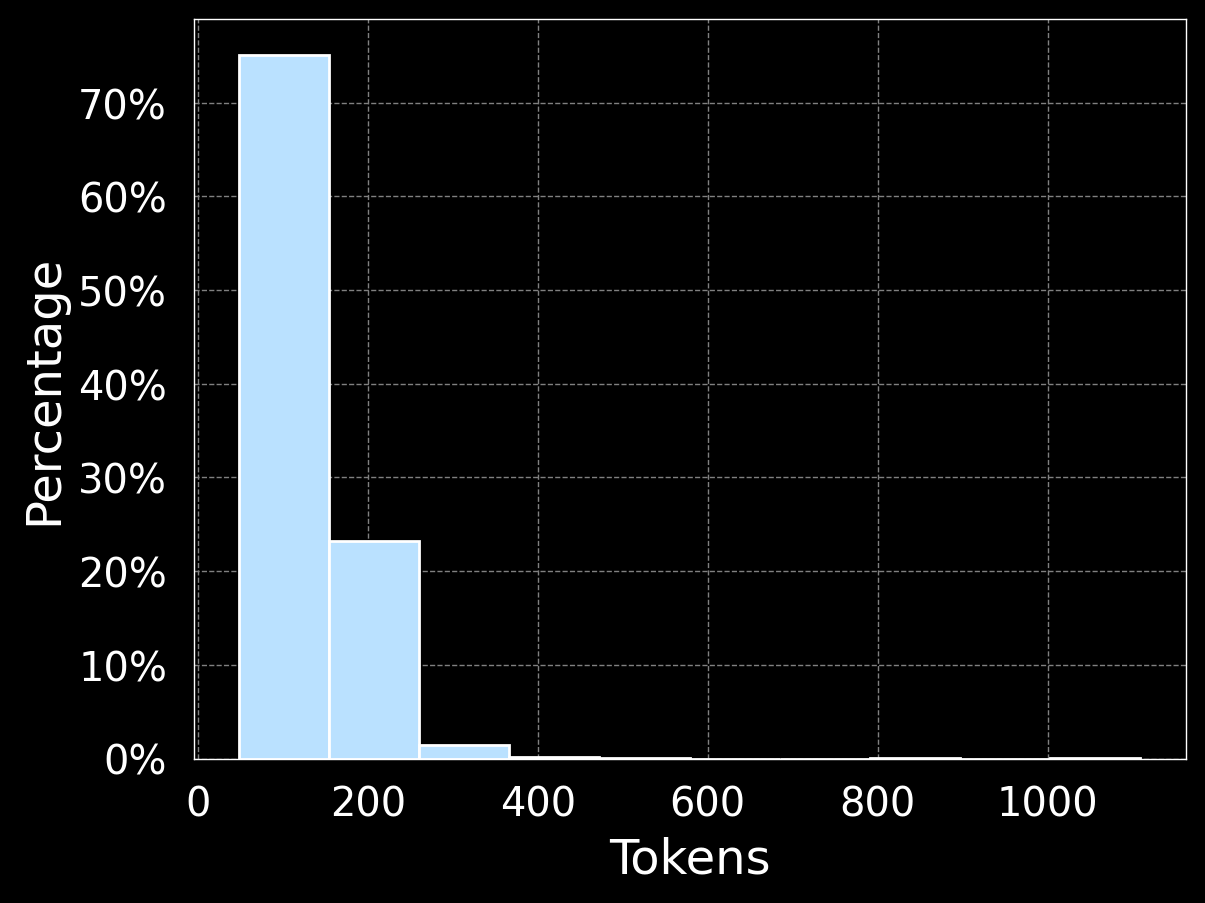

In [37]:
plt.hist(df.tokens_count, weights=np.ones(len(df.tokens_count)) / len(df.tokens_count))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Tokens")
plt.ylabel("Percentage")
plt.show()

In [39]:
df = df[df.tokens_count < 512]
df = df.sample(6000)
df.shape

(6000, 5)

In [40]:
train, temp = train_test_split(df, test_size=0.2)
val, test = train_test_split(temp, test_size=0.2)

In [45]:
len(train), len(val), len(test), len(df)

(4800, 960, 240, 6000)

In [43]:
len(train) / len(df), len(val) / len(df), len(test) / len(df)

(0.8, 0.16, 0.04)

## Data Preparation
Sampling Data & Exporting to JSON
- sampling data from three different DataFrames (train, val, and test) and exporting those samples to JSON files
- By exporting these subsets to JSON, easily share them or use them in different environments or applications.

In [46]:
train.sample(n=4000).to_json("train.json", orient="records", lines=True)
val.sample(n=500).to_json("val.json", orient="records", lines=True)
test.sample(n=100).to_json("test.json", orient="records", lines=True)

In [47]:
dataset = load_dataset(
    "json",
    data_files={"train": "train.json", "validation": "val.json", "test": "test.json"},
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [48]:
dataset


DatasetDict({
    train: Dataset({
        features: ['question', 'context', 'answer', 'text', 'tokens_count'],
        num_rows: 4000
    })
    validation: Dataset({
        features: ['question', 'context', 'answer', 'text', 'tokens_count'],
        num_rows: 500
    })
    test: Dataset({
        features: ['question', 'context', 'answer', 'text', 'tokens_count'],
        num_rows: 100
    })
})

In [49]:
print(dataset["train"][0]["text"])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

use only information to answer<|eot_id|><|start_header_id|>user<|end_header_id|>

What is the impact of the new $1.25 price point on Dollar Tree’s sales units and profitability?

INFORMATION:

```
To date, the increase in the price point has more than offset the decline in the number of units sold.
```<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The increase to a $1.25 price point at Dollar Tree stores has more than offset the decline in the number of units sold, suggesting a positive impact on profitability.<|eot_id|>
